In [2]:
!pip install opencv-python tensorflow imageio==2.23.0 gdown==4.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


#### Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
import numpy as np
from typing import List

**Check and limit GPU usage**

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [5]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url=url, output=output, quiet=False)
gdown.extractall(output)

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 122MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

**Data Loading Function**

In [8]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []

  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)

    # isolate mouth region
    frames.append(frame[190:236, 80:220, :])
  cap.release()

  # scaling data
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std

In [9]:
# vocabulary for lip reading
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


***Kind of encoding the letters and numbers***

In [11]:
char_to_num(['a', 'm', 'i', 't'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 13,  9, 20])>

In [12]:
num_to_char([ 1, 13,  9, 20])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'm', b'i', b't'], dtype=object)>

**Load alignments (labels)**

In [56]:
def load_alignments(path:str) -> List[str]:
  with open(path, 'r') as f:
    lines = f.readlines()

  tokens = []
  for line in lines:
    line = line.split()

    # ignore lines with silence
    if line[2] != 'sil':
      tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

**Load video and alignments together**

In [73]:
def load_data(path:str):
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split('.')[0]
  #file_name = path.split('\\')[-1].split('.')[0]
  video_path = os.path.join('data', 's1', f'{file_name}.mpg')
  alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

***Let's use a test sample***

In [59]:
test_sample = '.\\data\\s1\\bbaf2n.mpg'

In [60]:
tf.convert_to_tensor(test_sample).numpy().decode().split('\\')[-1].split('.')[0]

'bbaf2n'

In [61]:
test_sample_process = load_data(tf.convert_to_tensor(test_sample))
test_sample_process

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4616871 ],
          [1.4616871 ],
          [1.4991663 ],
          ...,
          [0.3373124 ],
          [0.3373124 ],
          [0.3373124 ]],
 
         ...,
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.11243746],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.07495831],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.07495831],
    

In [62]:
num_of_frames, height, width, num_of_channels = test_sample_process[0].shape

print(f"No. of frames: {num_of_frames}\n"
      f"Dimensions of frame: {(height, width)}\n"
      f"No. of channels: {num_of_channels}")

No. of frames: 75
Dimensions of frame: (46, 140)
No. of channels: 1


In [63]:
frames, alignments = test_sample_process

In [64]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

***Check test frame***

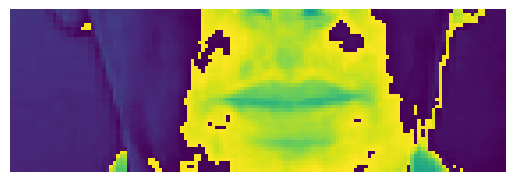

In [65]:
plt.axis('off')
plt.imshow(frames[21])
plt.show()

***Check test alignment***

In [66]:
test_alignments = [bytes.decode(x) for x in num_to_char(alignments).numpy()]
tf.strings.reduce_join(test_alignments).numpy().decode()

'bin blue at f two now'

In [67]:
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

#### 2. Build Data Pipeline

In [77]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [25]:
len(train)

450

In [26]:
len(test)

50

*After loading with list_files*

In [38]:
data.as_numpy_iterator().next()

b'./data/s1/brbm8p.mpg'

*After mapping the data*

set green with x three soon


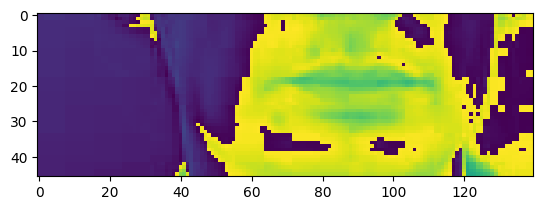

In [76]:
frames, alignments = data.as_numpy_iterator().next()
test_alignments = [bytes.decode(x) for x in num_to_char(alignments).numpy()]
print(tf.strings.reduce_join(test_alignments).numpy().decode())
plt.imshow(frames[0])
plt.show()

*After padding -> if few sentences are of different length 0 will be added to make all uniform*

In [78]:
frames, alignments = data.as_numpy_iterator().next()
alignments

array([[12,  1, 25, 39,  2, 12, 21,  5, 39,  1, 20, 39, 25, 39, 26,  5,
        18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 18, 39, 20,
        23, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [79]:
len(frames)

2

***Let's visualize***

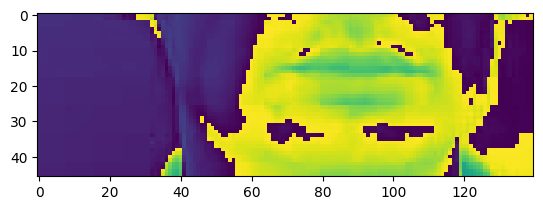

In [80]:
test_sample = data.as_numpy_iterator()
val = test_sample.next()
plt.imshow(val[0][1][0])
plt.show()

*Make a gif out of the video frames*

In [81]:
imageio.mimsave('./animation.gif', val[0][1])

#### 3. Design the Deep Learning Model

**Import dependencies**

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [83]:
data.as_numpy_iterator().next()[0].shape

(2, 75, 46, 140, 1)

In [84]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

*Let's test our model for once*

In [86]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [87]:
tf.argmax(yhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20])>

In [88]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]]).numpy().decode()

'rrrrttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt'

In [89]:
model.input_shape

(None, 75, 46, 140, 1)

In [90]:
model.output_shape

(None, 75, 41)

#### 4. Setup Training Options and Train

In [91]:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [92]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [93]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [94]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [95]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [96]:
schedule_callback = LearningRateScheduler(scheduler)

In [97]:
example_callback = ProduceExample(data)

In [98]:
model.fit(data, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/10
1/1 [==============================] - 2s 2s/step
Original: lay white in r three soon
Prediction: le e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red at e five again
Prediction: l e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 [==============================] - 518s 994ms/step - loss: 83.3809 - lr: 1.0000e-04
Epoch 2/10
 22/500 [>.............................] - ETA: 7:39 - loss: 73.1258

KeyboardInterrupt: 

#### 5. Make Predictions

In [99]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 186MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [106]:
model.load_weights('models/checkpoint')

In [105]:
model.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

In [107]:
test_data = test.as_numpy_iterator()

In [108]:
sample = test_data.next()

In [109]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 277ms/step


In [110]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by e zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by s three again'>]

In [111]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [112]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by e zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by s three again'>]

#### 6. Test on Video

In [114]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [115]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [116]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [117]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [118]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]